Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


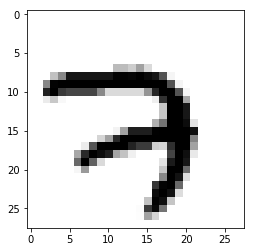

In [4]:
import tensorflow as tf
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
#Show the first training image
plt.imshow(mnist.train.images[0].reshape((28, 28), order='C'), cmap='Greys',  interpolation='nearest')

In [5]:
# Parameters
batch_size = 128
learning_rate = 0.05
number_iterations = 2000
steps = 10

# Network Parameters
n_input = 784 # 28x28 images
n_classes = 10 # 10 digit classes
dropout = 0.80 # Dropout probability

# tf Graph input
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

Iter 1280, Minibatch Loss= 39.037300, Training Accuracy= 0.10156
Testing Accuracy: 0.09375


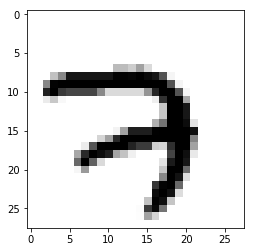

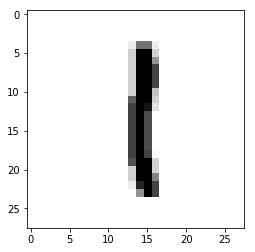

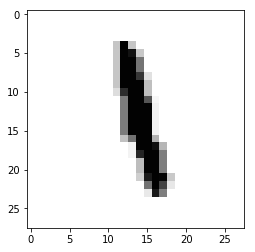

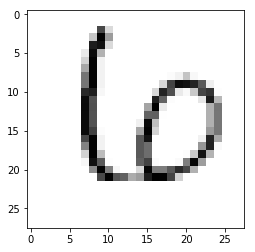

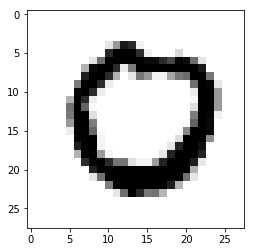

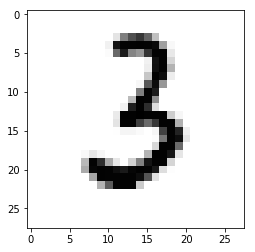

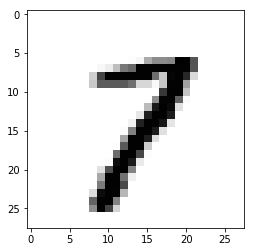

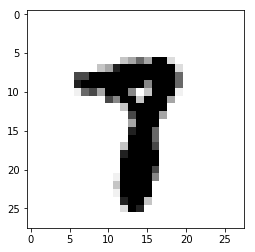

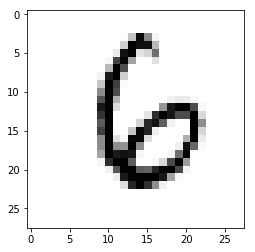

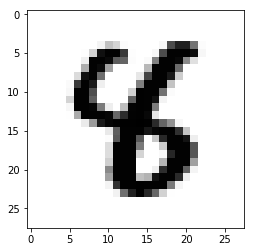

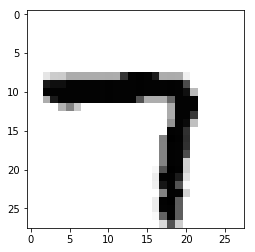

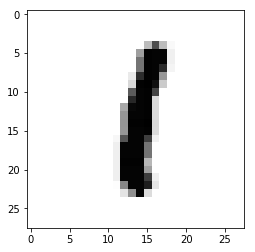

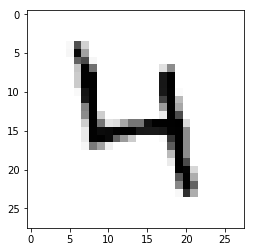

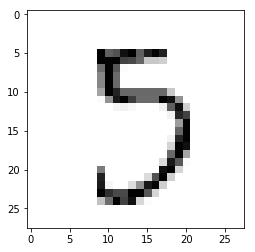

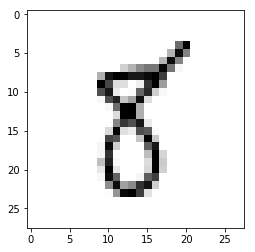

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def subsampling(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x_in, weights, biases, dropout):
    # Reshape input picture
    x_in = tf.reshape(x_in, shape=[-1, 28, 28, 1])

    # Convolution Layer 1
    conv_layer_1 = conv2d(x_in, weights['wc1'], biases['bc1'])
    # Subsampling
    conv_layer_1 = subsampling(conv_layer_1, k=2)

    # Convolution Layer 2
    conv_layer_2 = conv2d(conv_layer_1, weights['wc2'], biases['bc2'])
    # Subsampling
    conv_layer_2 = subsampling(conv_layer_2, k=2)

    # Fully connected layer
    # Reshape conv_layer_2 output to fit fully connected layer input
    fully_connected_layer = tf.reshape(conv_layer_2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fully_connected_layer = tf.add(tf.matmul(fully_connected_layer, weights['wd1']), biases['bd1'])
    fully_connected_layer = tf.nn.relu(fully_connected_layer)
    # Apply Dropout
    fully_connected_layer = tf.nn.dropout(fully_connected_layer, dropout)

    # Output, class prediction
    prediction_output = tf.add(tf.matmul(fully_connected_layer, weights['out']), biases['out'])
    return prediction_output

# Store layers weight & bias
weights = {
    # 5x5 convolutional units, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 convolutional units, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(X, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < number_iterations:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        test = batch_x[0]
        fig = plt.figure()
        plt.imshow(test.reshape((28, 28), order='C'), cmap='Greys',
                   interpolation='nearest')
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y,
                                       keep_prob: dropout})
        if step % steps == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={X: batch_x,
                                                              Y: batch_y,
                                                              keep_prob: 1.})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " +                   "{:.6f}".format(loss) + ", Training Accuracy= " +                   "{:.5f}".format(acc))
        step += 1

    # Calculate accuracy for 256 mnist test images
    print ("Testing Accuracy:",         sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.}))